In [69]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [45]:
# --- Load Data ---
df = pd.read_excel("C:/Users/rajes/OneDrive/Documents/data_ecommerce_customer_churn.xlsx")
print(df.head())

   Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0    15.0             29.0                         4  Laptop & Accessory   
1     7.0             25.0                         4              Mobile   
2    27.0             13.0                         3  Laptop & Accessory   
3    20.0             25.0                         4             Fashion   
4    30.0             15.0                         4              Others   

   SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
0                  3        Single                2         0   
1                  1       Married                2         0   
2                  1       Married                5         0   
3                  3      Divorced                7         0   
4                  4        Single                8         0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                7.0          143.32      0  
1                7.0          129.29      0  
2             

In [49]:
#  Handle Missing Values

df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])

# label encoders for each categorical column 

le_order = LabelEncoder()
le_marital = LabelEncoder()

df['PreferedOrderCat'] = le_order.fit_transform(df['PreferedOrderCat'].astype(str))
df['MaritalStatus'] = le_marital.fit_transform(df['MaritalStatus'].astype(str))

In [51]:
# Separate Features & Target 
X = df.drop('Churn', axis=1)
y = df['Churn']

# --- Balance Data using SMOTE ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Balanced data class counts:")
print(y_res.value_counts(), "\n")


Balanced data class counts:
Churn
0    3267
1    3267
Name: count, dtype: int64 



In [55]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Scaling Numeric Columns 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)



In [57]:
# Train Model (XGBoost)
model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      1011
           1       0.95      0.97      0.96       950

    accuracy                           0.96      1961
   macro avg       0.96      0.96      0.96      1961
weighted avg       0.96      0.96      0.96      1961

Optimal Threshold: 0.41


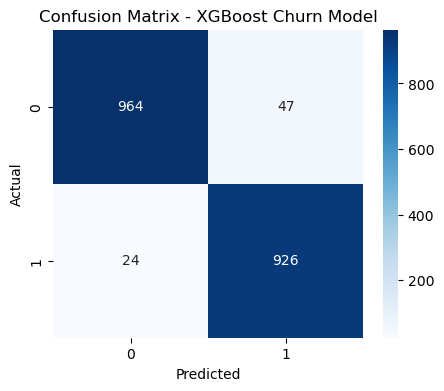

In [59]:
# --- Evaluate ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Find Optimal Threshold ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost Churn Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [65]:
# --- New Customer Predictions ---
new_customers = pd.DataFrame([
    {'Tenure':10, 'WarehouseToHome':20, 'NumberOfDeviceRegistered':3, 'PreferedOrderCat':le_order.transform(['Mobile'])[0],
     'SatisfactionScore':2, 'MaritalStatus':le_marital.transform(['Single'])[0], 'NumberOfAddress':4, 'Complain':1,
     'DaySinceLastOrder':6, 'CashbackAmount':150},
    {'Tenure':5, 'WarehouseToHome':10, 'NumberOfDeviceRegistered':2, 'PreferedOrderCat':le_order.transform(['Fashion'])[0],
     'SatisfactionScore':1, 'MaritalStatus':le_marital.transform(['Divorced'])[0], 'NumberOfAddress':3, 'Complain':1,
     'DaySinceLastOrder':40, 'CashbackAmount':60},
    {'Tenure':40, 'WarehouseToHome':15, 'NumberOfDeviceRegistered':6, 'PreferedOrderCat':le_order.transform(['Laptop & Accessory'])[0],
     'SatisfactionScore':5, 'MaritalStatus':le_marital.transform(['Married'])[0], 'NumberOfAddress':2, 'Complain':0,
     'DaySinceLastOrder':3, 'CashbackAmount':300},
    {'Tenure':3, 'WarehouseToHome':50, 'NumberOfDeviceRegistered':1, 'PreferedOrderCat':le_order.transform(['Grocery'])[0],
     'SatisfactionScore':1, 'MaritalStatus':le_marital.transform(['Single'])[0], 'NumberOfAddress':5, 'Complain':1,
     'DaySinceLastOrder':60, 'CashbackAmount':30}
])

# --- Scale new data ---
new_customers_scaled = pd.DataFrame(scaler.transform(new_customers), columns=X.columns)
new_probs = model.predict_proba(new_customers_scaled)[:, 1]
new_pred = (new_probs >= optimal_threshold).astype(int)

# --- Combine Results ---
new_customers['Churn_Probability'] = new_probs.round(2)
new_customers['Prediction'] = np.where(new_pred == 1, "Churn", "Not Churn")
print("\n🧾 New Customer Predictions:\n", new_customers)



🧾 New Customer Predictions:
    Tenure  WarehouseToHome  NumberOfDeviceRegistered  PreferedOrderCat  \
0      10               20                         3                 3   
1       5               10                         2                 0   
2      40               15                         6                 2   
3       3               50                         1                 1   

   SatisfactionScore  MaritalStatus  NumberOfAddress  Complain  \
0                  2              2                4         1   
1                  1              0                3         1   
2                  5              1                2         0   
3                  1              2                5         1   

   DaySinceLastOrder  CashbackAmount  Churn_Probability Prediction  
0                  6             150               0.20  Not Churn  
1                 40              60               0.03  Not Churn  
2                  3             300               0.00  Not 

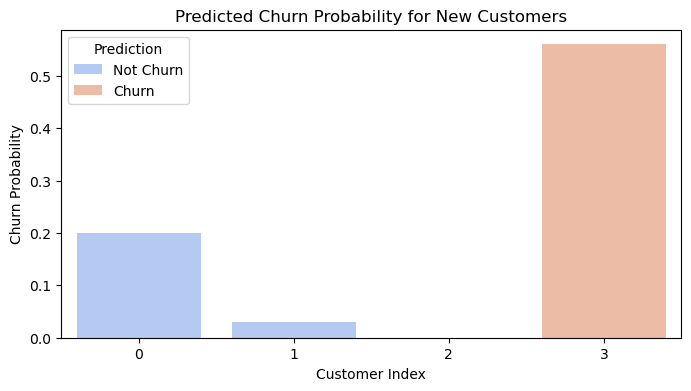

In [67]:
# --- Visualization ---
plt.figure(figsize=(8,4))
sns.barplot(x=new_customers.index, y=new_customers['Churn_Probability'], hue=new_customers['Prediction'], palette="coolwarm")
plt.title("Predicted Churn Probability for New Customers")
plt.xlabel("Customer Index")
plt.ylabel("Churn Probability")
plt.show()
